<a href="https://colab.research.google.com/github/ValerianFourel/DSReal/blob/main/NeuralNetwork/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import dask.dataframe as dd
import torch.nn as nn
import torch.nn.functional as F


## Loading of the data and dataframe

In [6]:
import zipfile

# Replace the zip_file_path with the path to the zip file in your Google Drive
zip_file_pathEvapo = '/content/drive/MyDrive/dataEvapotranspirationTensor.zip'
zip_file_pathElevation = '/content/drive/MyDrive/dataElevationTensor.zip'
zip_file_pathLAI = '/content/drive/MyDrive/dataLAITensor.zip'
zip_file_pathLST = '/content/drive/MyDrive/dataLSTTensor.zip'
zip_file_pathMODIS2015 = '/content/drive/MyDrive/dataNPPTensor.zip'
zip_file_paths = [zip_file_pathEvapo,zip_file_pathElevation,zip_file_pathLAI,zip_file_pathLST,zip_file_pathMODIS2015]

# Replace the destination_folder with the path of the folder where you want to extract the contents
destination_folderEvapo = '/content/dataEvapotranspiration'
destination_folderElevation = '/content/dataElevation'
destination_folderLAI = '/content/dataLAI/'
destination_folderLST = '/content/dataLST'
destination_folderMODIS = '/content/dataNPP'
destination_folders = [destination_folderEvapo,destination_folderElevation,destination_folderLAI,destination_folderLST,destination_folderMODIS]

In [7]:
# Unzip the file

for i in range(len(destination_folders)):
  with zipfile.ZipFile(zip_file_paths[i], 'r') as zip_ref:
      zip_ref.extractall(destination_folders[i])


In [8]:
sampleCoordinatesElevationIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesElevationIDArrayPositionDf.parquet'
sampleCoordinatesElevationIDArrayPositionDf = dd.read_parquet(sampleCoordinatesElevationIDArrayPositionDf_file).compute()

sampleCoordinatesEvapoIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesEvapoIDArrayPositionDf.parquet'
sampleCoordinatesEvapoIDArrayPositionDf = dd.read_parquet(sampleCoordinatesEvapoIDArrayPositionDf_file).compute()

sampleCoordinatesLAIIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesLAIIDArrayPositionDf.parquet'
sampleCoordinatesLAIIDArrayPositionDf = dd.read_parquet(sampleCoordinatesLAIIDArrayPositionDf_file).compute()

sampleCoordinatesLSTIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesLSTIDArrayPositionDf.parquet'
sampleCoordinatesLSTIDArrayPositionDf = dd.read_parquet(sampleCoordinatesLSTIDArrayPositionDf_file).compute()

sampleCoordinatesNppIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesNppIDArrayPositionDf.parquet'
sampleCoordinatesNppIDArrayPositionDf = dd.read_parquet(sampleCoordinatesNppIDArrayPositionDf_file).compute()



In [9]:
sampleCoordinatesEvapoIDArrayPositionDf

,ID,x,y
0,190,348,548
1,254,334,341
2,70,315,239
3,254,303,530
4,298,221,506
...,...,...,...
945774,632,159,169
945775,27,417,421
945776,467,74,223
945777,483,494,178


In [10]:
import torch

file_path = "/content/dataEvapotranspiration/0.pt"

# Load the tensor from the file
try:
    tensor = torch.load(file_path)
    data_type = tensor.dtype
    if data_type == torch.float64:
        print("The tensor contains double values (float64).")
    elif data_type == torch.float32:
        print("The tensor contains float values (float32).")
    else:
        print("The tensor contains a different data type.")
except Exception as e:
    print("An error occurred:", e)


The tensor contains float values (float32).


# Dataset and DataLoader Prototype

In [11]:
def re_scale(data, new_min, new_max):
    # Calculate mean and center the data around zero
    mean = data.mean()
    min_value = data.min()
    max_value = data.max()
    centered_data = data - mean

    scaled_data = (centered_data - min_value) / (max_value - min_value)  # Scale between 0 and 1
    scaled_data = scaled_data * (new_max - new_min) + new_min  # Scale to new range


    return scaled_data

In [12]:

class CustomRasterDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataFrame, file_path, file_extension,windowSize,re_scale = False,new_min = -1,new_max = 1):
        'Initialization'
        self.re_scale = re_scale
        self.new_min  = new_min
        self.new_max = new_max
        self.dataFrame = dataFrame
        self.file_path = file_path
        self.file_extension = file_extension
        self.windowSize = windowSize
        self.offset = self.windowSize // 2


    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataFrame)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID =  self.dataFrame.iloc[index]['ID'] # str(ID).rstrip('.0')

        x = self.dataFrame.iloc[index]['x']
        y = self.dataFrame.iloc[index]['y']
        # Load data and get label
        fullArray = torch.load(self.file_path+ID+self.file_extension)
        # Determine the window for the square
        left = x - self.offset
        right = x + (self.offset + 1)
        top = y - self.offset
        bottom = y + (self.offset + 1)
        X = fullArray[left:right,top:bottom].clone().detach()  # Access value in gpu_dictElevation
        # if self.re_scale:
          # X =  re_scale(X,self.new_min,self.new_max)
        return X.unsqueeze(0)


# Normalization of the Data

In [13]:
import os
import torch

def min_max_scale(data, min_value, max_value, new_min, new_max):
    # Calculate mean and center the data around zero
    mean = data.mean()
    centered_data = data - mean

    scaled_data = (centered_data - min_value) / (max_value - min_value)  # Scale between 0 and 1
    scaled_data = scaled_data * (new_max - new_min) + new_min  # Scale to new range


    return scaled_data

def normalize_folder(input_folder, output_folder, new_min, new_max):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    min_value = float('inf')
    max_value = float('-inf')

    for filename in os.listdir(input_folder):
        if filename.endswith(".pt"):
            file_path = os.path.join(input_folder, filename)
            tensor = torch.load(file_path)

            min_value = min(min_value, tensor.min())
            max_value = max(max_value, tensor.max())

    for filename in os.listdir(input_folder):
        if filename.endswith(".pt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            tensor = torch.load(input_path)
            centered_scaled_tensor = min_max_scale(tensor, min_value, max_value, new_min, new_max)

            torch.save(centered_scaled_tensor, output_path)


In [14]:
file_pathEvapo = '/content/dataEvapotranspiration/'
file_pathElevation = '/content/dataElevation/'
file_pathLAI = '/content/dataLAI/'
file_pathLST = '/content/dataLST/'
file_pathNPP = '/content/dataNPP/'

In [15]:
normalize_folder('/content/dataEvapotranspiration/', '/content/dataEvapotranspirationNorm/', -1, 1)

In [16]:
file_pathEvapo = '/content/dataEvapotranspiration/'

# Forming the Datasets and DataLoaders for the bands

In [17]:
batch_sizeEvapo = 32
batch_sizeNPP = 32
batch_sizeElevation = 64
batch_sizeLAI = 64
batch_sizeLST = 32

In [18]:
file_extension = '.pt'
num_workers = 2

### 1. Evapotranspiration

In [79]:
windowSizeEvapo= 33
# Create the dataset instance
datasetEvapo = CustomRasterDataset(sampleCoordinatesEvapoIDArrayPositionDf, file_pathEvapo, file_extension,windowSizeEvapo,re_scale=True)

In [80]:

# Create a DataLoader for batching and parallel data loading (you can adjust batch_size and num_workers as needed)

dataLoaderEvapo = DataLoader(datasetEvapo, batch_size=batch_sizeEvapo, num_workers=num_workers, shuffle=True)

# Now you can use elevation_dataloader in your training loop to efficiently access the elevation values in gpu_dictElevation.


### 2. Elevation

In [21]:
windowSizeElevation = 35

# Create the dataset instance
datasetElevation = CustomRasterDataset(sampleCoordinatesElevationIDArrayPositionDf, file_pathElevation, file_extension,windowSizeElevation)

In [22]:

# Create a DataLoader for batching and parallel data loading (you can adjust batch_size and num_workers as needed)

dataLoaderElevation = DataLoader(datasetElevation, batch_size=batch_sizeElevation, num_workers=num_workers, shuffle=True)

# Now you can use dataLoaderEvapo in your training loop to efficiently access the elevation values in gpu_dictElevation.


### 3. LAI

In [23]:
windowSizeLAI = 35
datasetLAI = CustomRasterDataset(sampleCoordinatesLAIIDArrayPositionDf, file_pathLAI, file_extension,windowSizeLAI)

In [24]:
dataLoaderLAI = DataLoader(datasetLAI, batch_size=batch_sizeLAI, num_workers=num_workers, shuffle=True)


### 4. LST

In [25]:
windowSizeLST = 17
datasetLST = CustomRasterDataset(sampleCoordinatesLSTIDArrayPositionDf, file_pathLST, file_extension,windowSizeLST)

In [26]:
dataLoaderLST = DataLoader(datasetLST, batch_size=batch_sizeLST, num_workers=num_workers, shuffle=True)


### 5. NPP

In [27]:
windowSizeNPP = 35
datasetNPP = CustomRasterDataset(sampleCoordinatesNppIDArrayPositionDf, '/content/dataNPP/', file_extension,windowSizeNPP)


In [28]:
dataLoaderNPP = DataLoader(datasetNPP, batch_size=batch_sizeNPP, num_workers=num_workers, shuffle=True)


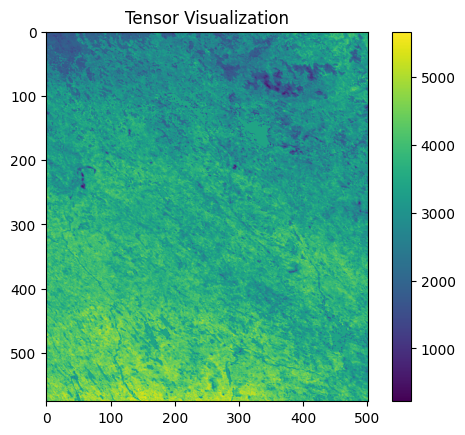

In [29]:
import torch
import matplotlib.pyplot as plt

# Load the tensor from the .pt file
tensor_path = '/content/dataNPP/122.pt'
loaded_tensor = torch.load(tensor_path)

# Convert the tensor to a NumPy array
numpy_array = loaded_tensor.numpy()

# Plot the NumPy array
plt.imshow(numpy_array, cmap='viridis')  # Use appropriate colormap
plt.colorbar()
plt.title("Tensor Visualization")
plt.show()


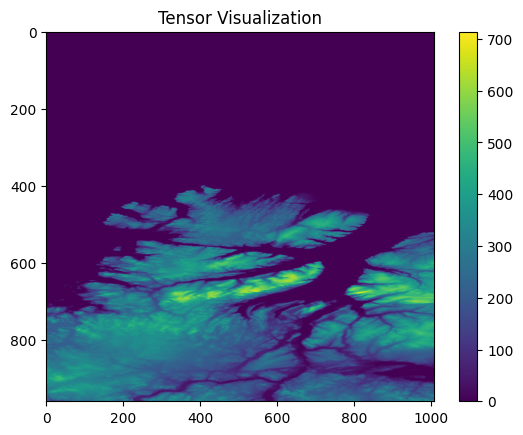

In [30]:

# Load the tensor from the .pt file
tensor_path = '/content/dataElevation/167.pt'
loaded_tensor = torch.load(tensor_path)

# Convert the tensor to a NumPy array
numpy_array = loaded_tensor.numpy()

# Plot the NumPy array
plt.imshow(numpy_array, cmap='viridis')  # Use appropriate colormap
plt.colorbar()
plt.title("Tensor Visualization")
plt.show()


In [81]:
# Assuming you have already created the 'elevation_dataloader' as mentioned in the previous steps

# Get the first batch from the dataloader using the 'next' function
first_batch = next(iter(dataLoaderEvapo))
second_batch = next(iter(dataLoaderEvapo))
# Print the content of the first batch
print("First Batch:")
print(first_batch.shape)


First Batch:
torch.Size([32, 1, 33, 33])


# Neural Network VAE

In [32]:
import torch.optim as optim

### Resnet

In [33]:
import torch
import torch.nn as nn
import torch.utils.data


class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return self.act_fnc(self.bn2(x + skip))


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2):
        super(ResUp, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x):
        x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))



### Elevation VAE

In [34]:

# Define the encoder network
class ElevationEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ElevationEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 4, 7, 1, 3)
        self.res_down_block1 = ResDown(4, 8)
        self.res_down_block2 = ResDown(8, 16)
        self.res_down_block3 = ResDown(16,32)
        self.res_down_block4 = ResDown(32, 64)
        self.conv_mu = nn.Conv2d(32, latent_dim, 3, 1)
        self.conv_log_var = nn.Conv2d(32, latent_dim, 3, 1)
        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class ElevationDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ElevationDecoder, self).__init__()
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 64, 4, 1)
        self.res_up_block1 = ResUp(64, 32)
        self.res_up_block2 = ResUp(32, 16)
        self.res_up_block3 = ResUp(16,8)
        self.res_up_block4 = ResUp(8,4)

        self.conv_out1 = nn.Conv2d(4, 2, 5, stride=3, padding=3)
        self.conv_out2 = nn.Conv2d(2, 1, 3, stride=1, padding=2)
        # self.conv_out3 = nn.Conv2d(2, 1, 3, 1, 1)

        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        x = self.res_up_block4(x)  # 32

        x = F.relu(self.conv_out1(x))
        x = self.conv_out2(x)
        # x = torch.tanh(self.conv_out3(x))
        return x

# Combine the encoder and decoder to form the VAE
class ElevationVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ElevationVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = ElevationEncoder(latent_dim)
        self.decoder = ElevationDecoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar

# Instantiate the VAE with the desired latent_dim
latent_dim = 25
vae = ElevationVAE(latent_dim)

# Pass the input batch through the VAE
reconstructed_batch, mu, logvar = vae(first_batch)

# Check the output shape
print("Reconstructed batch shape:", reconstructed_batch.shape)


Reconstructed batch shape: torch.Size([32, 1, 56, 56])


### Evapo VAE

In [82]:

# Define the encoder network
class EvapoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(EvapoEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 4, 7, 1, padding=1)
        self.res_down_block1 = ResDown(4, 8)
        self.res_down_block2 = ResDown(8, 16)
        self.res_down_block3 = ResDown(16,32)
        self.res_down_block4 = ResDown(32, 64)
        # self.res_down_block6 = ResDown(128, 256)

        self.flatten = nn.Flatten()
        self.conv_mu = nn.Linear(256, latent_dim,)
        self.conv_log_var = nn.Linear(256, latent_dim)
        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        x = self.res_down_block4(x)  # 8
        # x = self.res_down_block5(x)  # 8
        # x = self.res_down_block6(x)  # 8
        x =  self.flatten(x)
        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class EvapoDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(EvapoDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 256, 4, 2,padding=0)
        self.res_up_block1 = ResUp(256, 64)
        self.res_up_block2 = ResUp(64, 32)
        self.res_up_block3 = ResUp(32,16)
        self.res_up_block4 = ResUp(16,8)
        self.res_up_block5 = ResUp(8,4)
        self.res_down_block1 = ResDown(4,4)
        self.res_down_block2 = ResDown(4,8)
        self.res_up_block6 = ResUp(8,4)


        self.conv_out1 = nn.Conv2d(16, 1, 2, stride=1, padding=1)
        self.conv_out2 = nn.Conv2d(1, 4, 3, stride=1, padding=1)
        self.conv_out3 = nn.Conv2d(4, 1, 4, stride=1, padding=1)
        self.conv_out4 = nn.Conv2d(64, 8, 3, stride=1, padding=1)
        self.conv_out5 = nn.Conv2d(1, 1, 3, stride=1, padding=1)

        # self.conv_out3 = nn.Conv2d(2, 1, 3, 1, 1)

        self.act_fnc1 = nn.ELU()
        self.act_fnc2 = nn.ELU()
        self.act_fnc3 = nn.ELU()
        self.act_fnc4 = nn.ELU()
        self.act_fnc5 = nn.ELU()


    def forward(self, x):
        x = x.view(x.shape[0], self.latent_dim, 1, 1)  # Reshape into a 5x5 tensor
        x = F.relu(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        #x = self.res_up_block4(x)  # 32
        #x = self.res_up_block5(x)  # 32
        #x = self.res_down_block1(x)
        x = self.conv_out1(x)
        x_final = self.conv_out2(x)
        x_final = self.res_down_block2(x_final)
        x_final =  self.res_up_block6(x_final)
        # x_l1 = self.act_fnc1(self.conv_out1(x))
        # x_final = self.act_fnc2(self.conv_out2(x_l1))
        # x_final = self.act_fnc3(self.conv_out3(x_final))
        # x_final = self.act_fnc4(self.conv_out4(x_final))
        # x_final = self.act_fnc5(self.conv_out5(x))
        x_final = self.conv_out3(x_final)
        return x_final, x

# Combine the encoder and decoder to form the VAE
class EvapoVAE(nn.Module):
    def __init__(self, latent_dim):
        super(EvapoVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = EvapoEncoder(self.latent_dim)
        self.decoder = EvapoDecoder(self.latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x, x_l1 = self.decode(z)
        return reconstructed_x, x_l1, mu, logvar


# Instantiate the VAE with the desired latent_dim
latent_dim = 25
vae = EvapoVAE(5 * 5)

# Pass the input batch through the VAE
reconstructed_batch, x_l1, mu, logvar = vae(first_batch)

# Check the output shape
print("Reconstructed batch shape:", reconstructed_batch.shape)
print("Reconstructed batch shape:", x_l1.shape)


Reconstructed batch shape: torch.Size([32, 1, 33, 33])
Reconstructed batch shape: torch.Size([32, 1, 33, 33])


### LAI VAE

In [36]:

# Define the encoder network
class LAIEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(LAIEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 4, 7, 1, 3)
        self.res_down_block1 = ResDown(4, 8)
        self.res_down_block2 = ResDown(8, 16)
        self.res_down_block3 = ResDown(16,32)
        self.res_down_block4 = ResDown(32, 64)
        self.conv_mu = nn.Conv2d(32, latent_dim, 3, 1)
        self.conv_log_var = nn.Conv2d(32, latent_dim, 3, 1)
        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8

        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class LAIDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(LAIDecoder, self).__init__()
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 64, 4, 1)
        self.res_up_block1 = ResUp(64, 32)
        self.res_up_block2 = ResUp(32, 16)
        self.res_up_block3 = ResUp(16,8)
        self.res_up_block4 = ResUp(8,4)

        self.conv_out1 = nn.Conv2d(4, 2, 5, stride=3, padding=3)
        self.conv_out2 = nn.Conv2d(2, 1, 3, stride=1, padding=2)
        # self.conv_out3 = nn.Conv2d(2, 1, 3, 1, 1)

        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        x = self.res_up_block4(x)  # 32

        x = F.relu(self.conv_out1(x))
        x = self.conv_out2(x)
        # x = torch.tanh(self.conv_out3(x))
        return x

# Combine the encoder and decoder to form the VAE
class LAIVAE(nn.Module):
    def __init__(self, latent_dim):
        super(LAIVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = LAIEncoder(latent_dim)
        self.decoder = LAIDecoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar

# Instantiate the VAE with the desired latent_dim
latent_dim = 10
vae = LAIVAE(latent_dim)

# Pass the input batch through the VAE
reconstructed_batch, mu, logvar = vae(first_batch)

# Check the output shape
print("Reconstructed batch shape:", reconstructed_batch.shape)



Reconstructed batch shape: torch.Size([32, 1, 56, 56])


### Npp VAE

In [37]:

# Define the encoder network
class NppEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(NppEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 4, 7, 1, 3)
        self.res_down_block1 = ResDown(4, 8)
        self.res_down_block2 = ResDown(8, 16)
        self.res_down_block3 = ResDown(16,32)
        self.res_down_block4 = ResDown(32, 64)
        self.conv_mu = nn.Conv2d(32, latent_dim, 3, 1)
        self.conv_log_var = nn.Conv2d(32, latent_dim, 3, 1)
        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class NppDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(NppDecoder, self).__init__()
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 64, 4, 1)
        self.res_up_block1 = ResUp(64, 32)
        self.res_up_block2 = ResUp(32, 16)
        self.res_up_block3 = ResUp(16,8)
        self.res_up_block4 = ResUp(8,4)

        self.conv_out1 = nn.Conv2d(4, 2, 5, stride=3, padding=3)
        self.conv_out2 = nn.Conv2d(2, 1, 3, stride=1, padding=2)
        # self.conv_out3 = nn.Conv2d(2, 1, 3, 1, 1)

        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        x = self.res_up_block4(x)  # 32

        x = F.relu(self.conv_out1(x))
        x = self.conv_out2(x)
        # x = torch.tanh(self.conv_out3(x))
        return x

# Combine the encoder and decoder to form the VAE
class NppVAE(nn.Module):
    def __init__(self, latent_dim):
        super(NppVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = NppEncoder(latent_dim)
        self.decoder = NppDecoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar



### LST Encoder

In [38]:

# Define the encoder network
class LSTEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(LSTEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 4, 7, 1, 3)
        self.res_down_block1 = ResDown(4, 8)
        self.res_down_block2 = ResDown(8, 16)
        self.res_down_block3 = ResDown(16,32)
        self.res_down_block4 = ResDown(32, 64)
        self.conv_mu = nn.Conv2d(32, latent_dim, 3, 1)
        self.conv_log_var = nn.Conv2d(32, latent_dim, 3, 1)
        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class LSTDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(LSTDecoder, self).__init__()
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 64, 4, 1)
        self.res_up_block1 = ResUp(64, 32)
        self.res_up_block2 = ResUp(32, 16)
        self.res_up_block3 = ResUp(16,4)
        self.res_down_block1 = ResDown(4, 2)

        self.conv_out1 = nn.Conv2d(4, 2, 5, stride=2, padding=3)
        self.conv_out2 = nn.Conv2d(2, 1, 2, stride=1, padding=1)
        # self.conv_out3 = nn.Conv2d(2, 1, 3, 1, 1)

        self.act_fnc1 = nn.ELU()
        self.act_fnc2 = nn.ELU()


    def forward(self, x):
        x = self.act_fnc1(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        x = self.res_down_block1(x)
        # x = self.act_fnc2(self.conv_out1(x))
        x = self.conv_out2(x)
        # x = torch.tanh(self.conv_out3(x))
        return x

# Combine the encoder and decoder to form the VAE
class LSTVAE(nn.Module):
    def __init__(self, latent_dim):
        super(LSTVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = LSTEncoder(latent_dim)
        self.decoder = LSTDecoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar



# Training the VAEs

In [39]:
import torch.nn as nn

In [40]:
# Instantiate the VAE with the desired latent_dim
latent_dim = 30
vae = NppVAE(latent_dim)

# Pass the input batch through the VAE
reconstructed_batch, mu, logvar = vae(first_batch)

# Check the output shape
print("Reconstructed batch shape:", reconstructed_batch.shape)


Reconstructed batch shape: torch.Size([32, 1, 56, 56])


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:

class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, reconstructed_x, x_l1, x, mu, logvar):
        # Compute the Mean Squared Error (MSE) reconstruction loss
       # mse_loss = nn.MSELoss(reduction='mean')(reconstructed_x, x)
        # Create the L1 loss function
        loss_value_l1 = nn.L1Loss(reduction='mean')(reconstructed_x,x)
        # Compute the KL divergence term
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Return the sum of the reconstruction loss and KL divergence term
        return kl_divergence + (loss_value_l1)*28000

In [43]:
import torch.nn.init as init

def reset_parameters(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Reset the weights and biases of Conv2d and Linear layers
            module.reset_parameters()
        elif isinstance(module, nn.BatchNorm2d):
            # Reset the running statistics of BatchNorm2d layers
            module.reset_running_stats()

# Assuming you have already instantiated the VAE
vae = EvapoVAE(latent_dim)

# Reinitialize the VAE's parameters
reset_parameters(vae)


In [44]:
learning_rateNPP = 0.0005
learning_rateLST = 0.001
learning_rateLAI = 0.0005
learning_rateEvapo = 0.0001
learning_rateElevation = 0.0005

In [87]:
latent_dimNPP = 10
latent_dimLST = 5
latent_dimEvapo = 20
latent_dimElevation = 10
latent_dimLAI = 10

In [46]:
def re_scale(data, new_min, new_max):
    # Calculate mean and center the data around zero
    mean = data.mean()
    min_value = data.min()
    max_value = data.max()
    centered_data = data - mean

    scaled_data = (centered_data - min_value) / (max_value - min_value)  # Scale between 0 and 1
    scaled_data = scaled_data * (new_max - new_min) + new_min  # Scale to new range


    return scaled_data

In [88]:

# Define the function to train the VAE
def train_vae(vae, dataloader, num_epochs, learning_rate):
    # Set the model to training mode
    vae.train()

    # Define the Mean Squared Error (MSE) loss function
    criterion = VAELoss()

    # Define the optimizer (you can experiment with different optimizers)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    total_batches = len(dataloader)
    batches_done = 0

    for epoch in range(num_epochs):
        total_loss = 0.0
        batches_done =0
        for batch_idx, data in enumerate(dataloader):
            # Get the batch of data and move it to the device (e.g., GPU if available)
            # inputs = data
            inputs = data
            inputs = inputs.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            reconstructed_batch, x_l1, mu, logvar = vae(inputs)
            # Compute the MSE loss
            loss = criterion(reconstructed_batch,x_l1, inputs,mu, logvar)

            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Update the total loss for the epoch
            total_loss += loss.item()

            # Update the number of batches processed
            batches_done += 1

            # Print the progress when a tenth of the epoch is completed
            if batches_done % (len(dataloader) // 10) == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] - Progress: {batches_done}/{len(dataloader)} - Total Loss: {total_loss / (len(dataloader) // 10)}")
                total_loss = 0

        # Print the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss / ((len(dataloader) - len(dataloader) //10 * 9 ) % 10)}")

# Example usage:'device = torch.device("cuda" if torch.cuda.is_available() else "cpu")'
# Assuming you have the training data in 'train_dataloader' and a device set, e.g.,
# Instantiate the VAE with the desired latent_dim
vae = EvapoVAE(latent_dimEvapo).to(device)

# Define the number of epochs and learning rate
num_epochs = 3


# Train the VAE
train_vae(vae, dataLoaderEvapo, num_epochs, learning_rateEvapo)

Epoch [1/3] - Progress: 2955/29556 - Total Loss: 4661977.313113367
Epoch [1/3] - Progress: 5910/29556 - Total Loss: 3940451.6776649747
Epoch [1/3] - Progress: 8865/29556 - Total Loss: 2859031.26857022
Epoch [1/3] - Progress: 11820/29556 - Total Loss: 1617732.74357022
Epoch [1/3] - Progress: 14775/29556 - Total Loss: 860410.9984031303
Epoch [1/3] - Progress: 17730/29556 - Total Loss: 596874.6874471235
Epoch [1/3] - Progress: 20685/29556 - Total Loss: 562880.3621615905
Epoch [1/3] - Progress: 23640/29556 - Total Loss: 551056.5024111675
Epoch [1/3] - Progress: 26595/29556 - Total Loss: 540073.6508989001
Epoch [1/3] - Progress: 29550/29556 - Total Loss: 534378.4659158207
Epoch [1/3] - Loss: 3155942.34375
Epoch [2/3] - Progress: 2955/29556 - Total Loss: 531887.031747039
Epoch [2/3] - Progress: 5910/29556 - Total Loss: 530096.6994712352
Epoch [2/3] - Progress: 8865/29556 - Total Loss: 527770.726818951
Epoch [2/3] - Progress: 11820/29556 - Total Loss: 527282.7860406091
Epoch [2/3] - Progress:

KeyboardInterrupt: ignored

In [62]:
train_vae(vae, dataLoaderEvapo, num_epochs, learning_rateEvapo)

Epoch [1/3] - Progress: 2955/29556 - Total Loss: 25865817.371235196
Epoch [1/3] - Progress: 5910/29556 - Total Loss: 25564502.70253807
Epoch [1/3] - Progress: 8865/29556 - Total Loss: 25194297.19458545
Epoch [1/3] - Progress: 11820/29556 - Total Loss: 25071032.319458544
Epoch [1/3] - Progress: 14775/29556 - Total Loss: 24983879.97529611
Epoch [1/3] - Progress: 17730/29556 - Total Loss: 24878296.786463622
Epoch [1/3] - Progress: 20685/29556 - Total Loss: 24744826.209813874
Epoch [1/3] - Progress: 23640/29556 - Total Loss: 24728531.320135362
Epoch [1/3] - Progress: 26595/29556 - Total Loss: 24734127.34890017


KeyboardInterrupt: ignored

# Plot Results of a VAE

In [89]:
def get_random_batch(dataloader):
    # Get the total number of batches in the DataLoader
    num_batches = len(dataloader)

    # Generate a random index to select a batch
    random_batch_index = torch.randint(0, 100, (1,))

    # Iterate through the DataLoader to find the batch at the random index
    for i, batch in enumerate(dataloader):
        if i == random_batch_index:
            return batch


In [90]:
randomBatch = get_random_batch(dataLoaderEvapo)

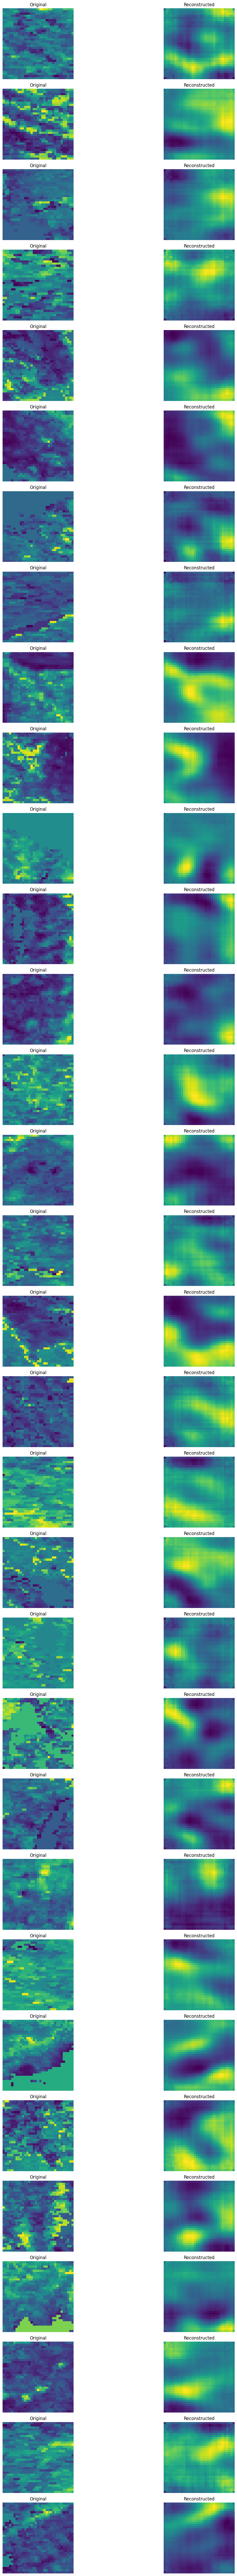

In [91]:
import torch
import matplotlib.pyplot as plt

def compare_vae_reconstruction(vae, data_batch, device):
    # Set the VAE to evaluation mode
    vae.eval()

    # Get the batch size and number of channels
    batch_size, num_channels, height, width = data_batch.size()

    # Get the reconstructed images from the VAE
    with torch.no_grad():
        reconstructed_batch, xf, _, _ = vae(data_batch.to(device))

    # Convert the tensors to numpy arrays and transpose the dimensions
    original_images = data_batch.cpu().numpy().transpose(0, 2, 3, 1)
    reconstructed_images = reconstructed_batch.cpu().numpy().transpose(0, 2, 3, 1)

    # Plot the original and reconstructed images side by side
    plt.figure(figsize=(100, 100))

    for i in range(batch_size):
        plt.subplot(batch_size, 16, i*16 + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title('Original')

        plt.subplot(batch_size, 16, i*16 + 2)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
        plt.title('Reconstructed')


    plt.tight_layout()
    plt.show()

# Usage
# Assuming 'vae' is your trained Variational Autoencoder model
# and 'data_batch' is your batch of input images
# 'device' should be the device on which your model is (e.g., 'cuda' or 'cpu')
compare_vae_reconstruction(vae, randomBatch, device)
